In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from torch.utils.data import random_split

from RawHandler.utils import linear_to_srgb, linear_to_srgb_torch
from RawRefinery.train.RawImagePatchDataset import RawImagePatchDataset
from Restorer.CombinedPerceptualLoss import CombinedPerceptualLoss, VGGPerceptualLoss


In [2]:
model_weight_path = '../weights/train_on_raws_trained_on_lin_rec2020_MS_SSIM_L1_VGG_GAN_initialize_ddfapd_removed_GAN.pt'
input_model_weight_path = '../weights/train_on_raws_trained_on_lin_rec2020_MS_SSIM_L1_VGG_GAN_initialize_ddfapd.pt'

GAN_weight_path ='../weights/patchGAN_noise_conditioned.pt'

In [3]:
dataset = RawImagePatchDataset('align.csv', patch_size=256, colorspace='lin_rec2020')

[Dataset] Filtered out 12 rows below cc threshold of 0.92.


/Users/ryanmueller/Develop/RawHandler/src/RawHandler/RawHandler.py:113: RuntimeWarning: divide by zero encountered in matmul
  transformed = (rggb_transform @ rggb.reshape(4, -1)).reshape(orig_dims)
/Users/ryanmueller/Develop/RawHandler/src/RawHandler/RawHandler.py:113: RuntimeWarning: overflow encountered in matmul
  transformed = (rggb_transform @ rggb.reshape(4, -1)).reshape(orig_dims)
/Users/ryanmueller/Develop/RawHandler/src/RawHandler/RawHandler.py:113: RuntimeWarning: invalid value encountered in matmul
  transformed = (rggb_transform @ rggb.reshape(4, -1)).reshape(orig_dims)


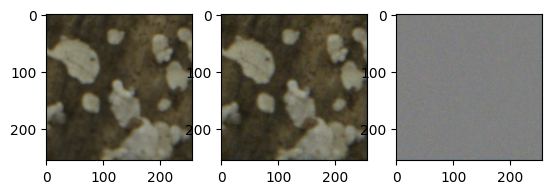

In [4]:
output = dataset[60]

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(linear_to_srgb(output['gt'].permute(1, 2, 0)))

plt.subplot(1, 3, 2)
plt.imshow(linear_to_srgb(output['noisy'].permute(1, 2, 0)))

plt.subplot(1, 3, 3)
plt.imshow(linear_to_srgb(output['noisy'].permute(1, 2, 0))-linear_to_srgb(output['gt'].permute(1, 2, 0))+0.5)

In [5]:
batch_size = 2
val_split = 0.2
test_split = 0.2

# Split dataset into train and val
val_size = int(len(dataset) * val_split)
test_size = int(len(dataset) * test_split)
train_size = len(dataset) - val_size - test_size
torch.manual_seed(42)  # For reproducibility
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [6]:
# Get the model
from RawRefinery.train.load_model import load_model

weight_file_path = input_model_weight_path
device = 'mps'
model = load_model(device, weight_file_path)
model = model.train()

/opt/homebrew/Caskroom/miniconda/base/envs/OnSight/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniconda/base/envs/OnSight/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [7]:
lr = 1e-4/4
clip = 8e-3
l2_reg = 0
num_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=lr*0.01)



In [8]:
import torch
import torch.nn as nn

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        def block(in_ch, out_ch, stride=2):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 4, stride, 1),
                nn.InstanceNorm2d(out_ch, affine=True),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.model = nn.Sequential(
            block(in_channels, base_channels),
            block(base_channels, base_channels * 2),
            block(base_channels * 2, base_channels * 4),
            block(base_channels * 4, base_channels * 8),
            nn.Conv2d(base_channels * 8, 1, 4, padding=1) 
        )
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        """
        Applies initial weights to all convolutional and normalization layers.
        """
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('InstanceNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        return self.model(x)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
disc = PatchDiscriminator(in_channels=6)
state_dict = torch.load(GAN_weight_path, map_location=torch.device('cpu'))
# disc.load_state_dict(state_dict, strict=False)


disc = disc.to(device)


disclr = lr
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=disclr, weight_decay=l2_reg)
disc_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(disc_optimizer, T_max=num_epochs, eta_min=disclr*0.01)
adversarial_loss = nn.BCEWithLogitsLoss()

In [10]:
import torch
import torch.nn.functional as F
from pytorch_msssim import ms_ssim

def gaussian_kernel(kernel_size=11, sigma=1.5, channels=3):
    """Creates a 2D Gaussian kernel for applying to each channel."""
    coords = torch.arange(kernel_size).float() - kernel_size // 2
    g = torch.exp(-(coords**2) / (2 * sigma**2))
    g = g / g.sum()
    kernel_2d = torch.outer(g, g)
    kernel_2d = kernel_2d / kernel_2d.sum()
    kernel_2d = kernel_2d.expand(channels, 1, kernel_size, kernel_size).contiguous()
    return kernel_2d

def gaussian_filter(x, kernel):
    """Applies Gaussian filter to each channel using depthwise convolution."""
    channels = x.shape[1]
    return F.conv2d(x, kernel, padding=kernel.shape[-1] // 2, groups=channels)
    


class MS_SSIM_L1_VGG_Loss(torch.nn.Module):
    def __init__(self, alpha=0.84, vgg_weight = .001, kernel_size=11, sigma=1.5, device=device):
        super().__init__()
        self.alpha = alpha
        self.vgg_weight = vgg_weight
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.vgg_loss = VGGPerceptualLoss(apply_gamma_curve=False)
        self.vgg_loss = self.vgg_loss.to(device)

    def forward(self, pred, target):


        # # Gaussian-weighted L1 loss
        abs_error = torch.abs(pred - target)
        # gauss = gaussian_kernel(kernel_size=self.kernel_size, sigma=self.sigma, channels=pred.shape[1]).to(pred.device)
        # weighted_l1 = gaussian_filter(abs_error, gauss)

        # # Mean over pixels and batch
        weighted_l1_loss = abs_error.mean()
        
        # VGG Loss 
        pred_gamma = linear_to_srgb_torch(pred)
        target_gamma = linear_to_srgb_torch(target)

        vgg_loss = self.vgg_loss(pred, target_gamma)

        # MS-SSIM term (averaged over batch)
        ms_ssim_loss = 1 - ms_ssim(pred_gamma, target_gamma, data_range=1.0, size_average=True)
        
        return self.alpha * ms_ssim_loss + (1 - self.alpha) * weighted_l1_loss + vgg_loss*self.vgg_weight



In [11]:
loss_func = MS_SSIM_L1_VGG_Loss()

/opt/homebrew/Caskroom/miniconda/base/envs/OnSight/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for epoch in range(num_epochs):
    # train
    model.train()
    print(epoch)
    n_images = 0
    total_loss = 0
    D_loss = 0
    loss_disc_total = 0
    for data in train_loader:
        input = data['noisy_rggb_tensor'].to(device)
        conditioning = data['conditioning'].to(device)
        gt = data['gt'].to(device)
        noisy = data['noisy'].to(device)

        # --- Train Disc. ---
        fake_output = model(input, conditioning).detach()
        fake_output = noisy + fake_output

        gt_d = torch.cat([noisy, gt], dim=1)
        pred_real = disc(gt_d)
        fake_output_d = torch.cat([noisy, fake_output], dim=1)
        pred_fake = disc(fake_output_d)

        loss_disc = 0.5 * (adversarial_loss(pred_real, torch.ones_like(pred_real)) +
                        adversarial_loss(pred_fake, torch.zeros_like(pred_fake)))
        
        disc_optimizer.zero_grad()
        loss_disc.backward()
        disc_optimizer.step()

        # --- Train model ---
        pred = model(input, conditioning)
        pred = noisy + pred

        loss = loss_func(pred, gt)
        pred_d = torch.cat([noisy, pred], dim=1)
        pred_fake = disc(pred_d)
        
        loss_adv = adversarial_loss(pred_fake, torch.ones_like(pred_fake)) * 0.005 * 0
        loss += loss_adv 

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),clip)
        optimizer.step()

        
        n_images += gt.size(0)
        # if n_images > 100: break
        total_loss += loss.item() * gt.size(0)
        D_loss += loss_adv.item() * gt.size(0)
        loss_disc_total+=loss_disc.item() * gt.size(0)

    torch.save(model.state_dict(), model_weight_path)
    torch.save(disc.state_dict(), GAN_weight_path)

    scheduler.step()
    disc_scheduler.step()

    # # print current learning rate
    lr = optimizer.param_groups[0]['lr']
    # # print(f'total_loss: {total_loss/n_images:.2e}  disc. loss {D_loss/n_images:.2e}, lr: {lr:.2e}')
    print(f'loss: {total_loss/n_images:.2e}  loss_adv: {D_loss/n_images:.2e}, loss_disc_total: {loss_disc_total/n_images:.2e} lr: {lr:.2e}')

0


/Users/ryanmueller/Develop/RawHandler/src/RawHandler/RawHandler.py:113: RuntimeWarning: divide by zero encountered in matmul
  transformed = (rggb_transform @ rggb.reshape(4, -1)).reshape(orig_dims)
/Users/ryanmueller/Develop/RawHandler/src/RawHandler/RawHandler.py:113: RuntimeWarning: overflow encountered in matmul
  transformed = (rggb_transform @ rggb.reshape(4, -1)).reshape(orig_dims)
/Users/ryanmueller/Develop/RawHandler/src/RawHandler/RawHandler.py:113: RuntimeWarning: invalid value encountered in matmul
  transformed = (rggb_transform @ rggb.reshape(4, -1)).reshape(orig_dims)


KeyboardInterrupt: 

In [13]:
torch.save(model.state_dict(), model_weight_path)